Empiricla Mode Decomposition is the way to decompose a complex signals into several simple mode signals like Fourie Analysis.

This analysis will be based on https://www.mql5.com/en/articles/439

# prepare for data

In [1]:
# generic
%matplotlib inline
from __future__ import print_function

# common
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# local
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter
from tseries.indicators import get_functions

# for testing purpose
from IPython import display
import platform
#import plotly
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import tqdm
import time
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

def list_packages_versions():
    !date
    print("\ncompiler    : %s"%platform.python_compiler())
    l = platform.linux_distribution()
    print("system      : %s, %s, %s, %s"%(platform.system(),platform.release(),l[0],l[1]))
    print("processor   : %s, %s\n"%(platform.processor(),platform.architecture()[0]))
    
    a = %who_ls module
    for i in a:
        try:
            print("%s %s"%(("%s (%s) "%(globals()[i].__name__,i)).ljust(20,'_'),globals()[i].__version__))
        except:
            pass
list_packages_versions()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Mon Jul 11 06:22:38 UTC 2016

compiler    : GCC 4.8.2
system      : Linux, 3.19.0-51-generic, Ubuntu, 14.04
processor   : x86_64, 64bit

json (json) ________ 2.0.9
numpy (np) _________ 1.11.0
pandas (pd) ________ 0.18.1
platform (platform)  1.0.7
seaborn (sns) ______ 0.7.1


In [157]:
parse_datetime = tm.T.parser("%Y%m%d%H%M")
reference_score = compare.load_reference(parse_json(load_json("/project/exp/reference/downtrend_2015test_1a.json")),
                                         "EURUSD", "5Min", parse_datetime("201501010000"),
                                         parse_datetime("201601010000"))

h5 = histdata.get_pandadb()
symbol="EURJPY"
timeframe="5Min"
df = h5[histdata.get_table_name(symbol, timeframe)]

beginning, end = "2015-01-02 08:00:00" , "2015-05-29 21:55:00"
ref = reference_score[beginning : end]
df = df[beginning : end]

ohlc_data = pd.concat([
        df.iloc[:13704],
        pd.DataFrame({"open":[129.636], "high": [129.589], "low": [129.586], "close": [129.58]},
                     index=[pd.to_datetime("2015-03-10 22:00:00+0000",utc=True)]),
        df.iloc[13704:]    
    ])

def df_to_array(df):
    data_list = []
    for key in df.columns:
        data_list.append(df[key])
    return np.array(data_list)

ohlc_array = df_to_array(ohlc_data)
high_data = np.array(ohlc_data['high'])
low_data = np.array(ohlc_data['low'])
open_data = np.array(ohlc_data["open"])
close_data = np.array(ohlc_data["close"])

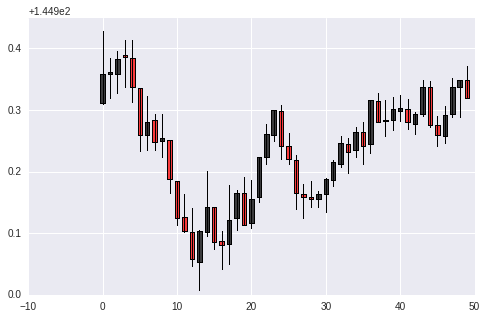

In [3]:
from matplotlib.finance import candlestick2_ohlc

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, ohlc_data["open"][:50], ohlc_data["high"][:50], 
                  ohlc_data["low"][:50], ohlc_data["close"][:50],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

Test for making envelops

In [62]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def get_locmax(data):
    """Return max index list"""
    n_data = len(data)
    max_idx = []
    # we will not take the edge points as maximum
    for i in xrange(1, n_data - 1):
        if data[i] >= data[i - 1] and data[i] >= data[i + 1]:
            max_idx.append(i)
    
    return max_idx

def compute_envelop(data, degree=3, is_max=True):
    """Return envelop data with local maximal(minimum)"""
    if is_max is False:
        data = -data
    
    n_data = len(data)
    index_data = np.arange(n_data)
    
    # select points for drawing line
    max_idx = get_locmax(data)
    locmax_data = data[max_idx]
    
    # reshape for regression
    X_pred = np.atleast_2d(index_data).T
    X_max = X_pred[max_idx]
    Y_max =  np.atleast_2d(locmax_data).T
    
    # interpolation
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    n_max_idx = len(max_idx)
    # if there is not so many local maimum, we don't have to smooth data
    if n_max_idx < degree:
        if is_max is False:
            data = -data
        return data
    
    envelop = []
    for idx in xrange(n_max_idx - degree + 1):
        # we choose the number of degree points for exact fitting 
        if idx == 0:
            beg = 0
        else:
            beg = max_idx[idx]
        
        if idx == n_max_idx - degree:
            end = n_data
        else:
            end = max_idx[idx + 1]
            
        pred_idx = np.arange(beg, end)
        
        X = X_max[idx:idx + degree]
        Y = Y_max[idx:idx + degree]
        model.fit(X, Y)
        prediction = model.predict(X_pred[pred_idx])[:, 0]
        envelop += list(prediction)
    
    envelop = np.array(envelop)
    if is_max is False:
        envelop = -envelop
    
    return envelop

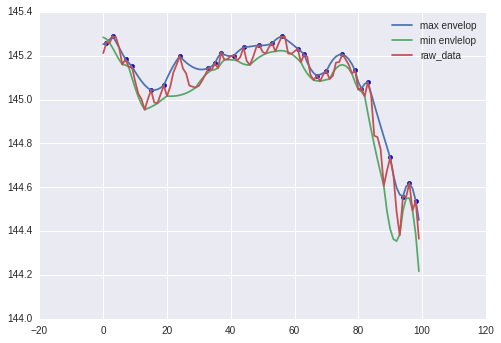

In [63]:
open_data_mini = open_data[:100]

max_envelop = compute_envelop(open_data_mini, is_max=True)
min_envelop = compute_envelop(open_data_mini, is_max=False)
x = get_locmax(open_data_mini)
y = open_data_mini[x]
plt.scatter(x, y)
plt.plot(max_envelop, label="max envelop")
plt.plot(min_envelop, label="min envlelop")
plt.plot(open_data_mini, label="raw_data")
plt.legend()

It looks nice!

# EMD

In [64]:
def EMD(data, n_step=5):
    """Return list of decomposition"""
    decomposed_data = []
    for i in xrange(n_step):
        max_env = compute_envelop(data, is_max=True)
        min_env = compute_envelop(data, is_max=False)
        mean =  0.5 * (max_env + min_env)
        decomposed_data.append(data - mean)
        data  = mean
    
    return decomposed_data

In [67]:
decomposed = EMD(open_data_mini, n_step=5)

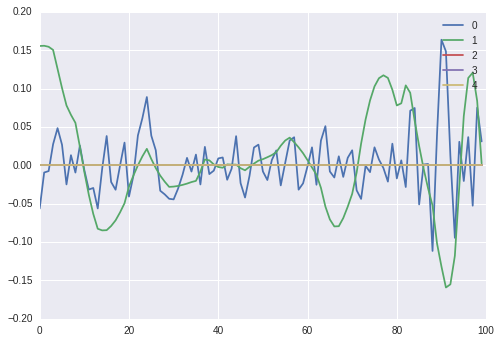

In [68]:
for idx, data in enumerate(decomposed):
    plt.plot(data, label=idx)
plt.legend()

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ridge.py:147: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


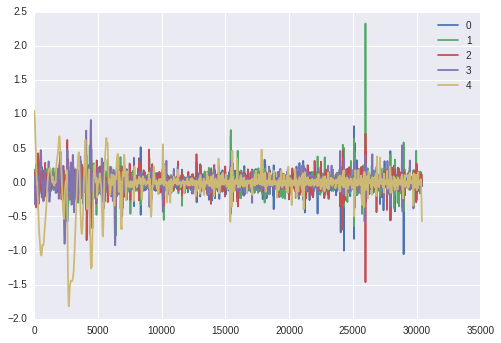

In [69]:
decomposed = EMD(open_data, n_step=5)
for idx, data in enumerate(decomposed):
    plt.plot(data, label=idx)
plt.legend()

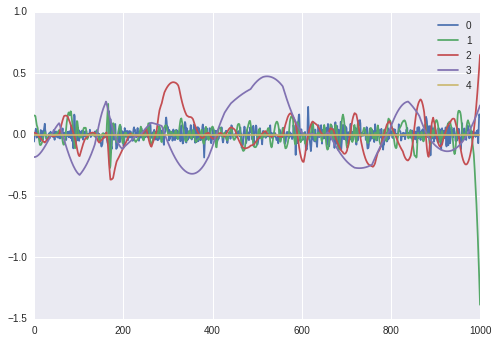

In [70]:
decomposed = EMD(open_data[:1000], n_step=5)
for idx, data in enumerate(decomposed):
    plt.plot(data, label=idx)
plt.legend()

In [103]:
def EMD2(data, n_step=10, eps=1e-2):
    """Return list of decomposition"""
    decomposed_data = []
    for i in xrange(n_step):
        max_env = compute_envelop(data, is_max=True)
        min_env = compute_envelop(data, is_max=False)
        mean =  0.5 * (max_env + min_env)
        d = data - mean
        if np.max(np.abs(d)) < eps:
            decomposed_data.append(mean)
            break
        decomposed_data.append(d)
    
        data  = mean
    
    return decomposed_data

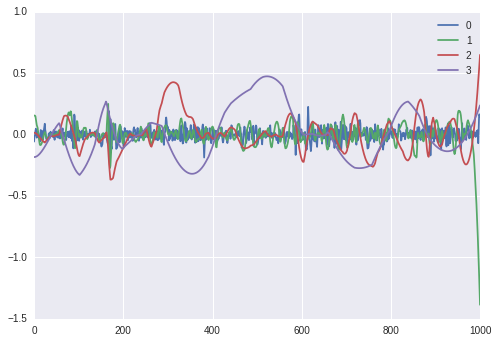

In [105]:
decomposed = EMD2(open_data[:1000], n_step=10)
for idx, data in enumerate(decomposed[:-1]):
    plt.plot(data, label=idx)
plt.legend()

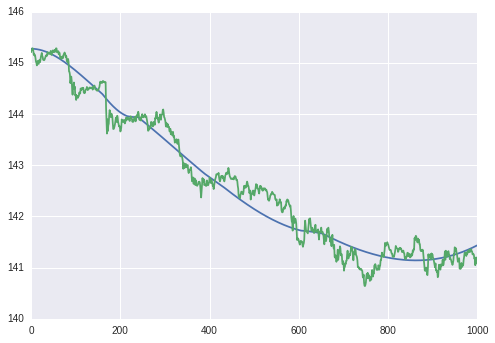

In [107]:
plt.plot(decomposed[-1])
plt.plot(open_data[:1000])

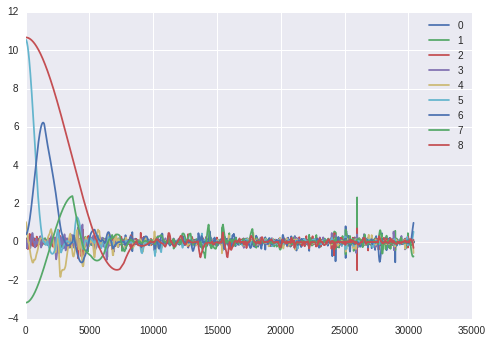

In [108]:
decomposed = EMD2(open_data, n_step=10)
for idx, data in enumerate(decomposed[:-1]):
    plt.plot(data, label=idx)
plt.legend()

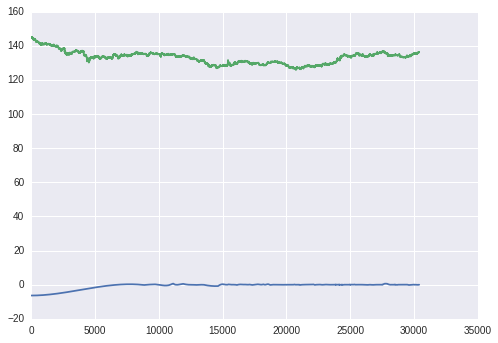

In [109]:
plt.plot(decomposed[-1])
plt.plot(open_data)

If data lenght is long, this doesn't work well because data is not stationary

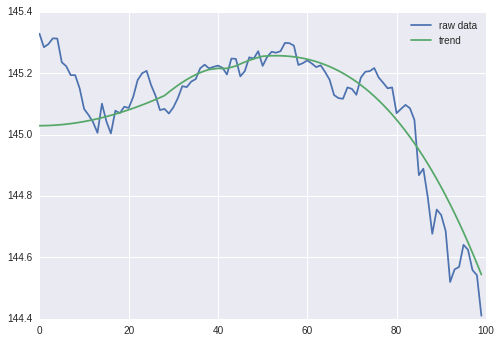

In [111]:
N = 0
M = 100
data_mini = high_data[N:M]
decomposed = EMD2(data_mini, n_step=100)
trend = decomposed[-1]
plt.plot(data_mini, label="raw data")
plt.plot(trend, label="trend")
plt.legend()

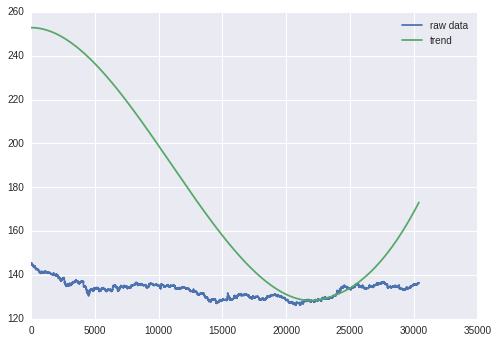

In [113]:
N = 0
M = -1
data_mini = high_data[N:M]
decomposed = EMD2(data_mini, n_step=100)
trend = decomposed[-1]
plt.plot(data_mini, label="raw data")
plt.plot(trend, label="trend")
plt.legend()

In [145]:
def EMD3(data, n_step=10, eps=1e-2):
    """Return list of decomposition"""
    decomposed_data = []
    for i in xrange(n_step):
        max_env = compute_envelop(data, is_max=True)
        min_env = compute_envelop(data, is_max=False)
        mean =  0.5 * (max_env + min_env)
        d = data - mean
        if np.max(np.abs(d)) < eps:
            break
        decomposed_data.append(d)
    
        data  = mean
        
    decomposed_data.append(mean)
    return decomposed_data

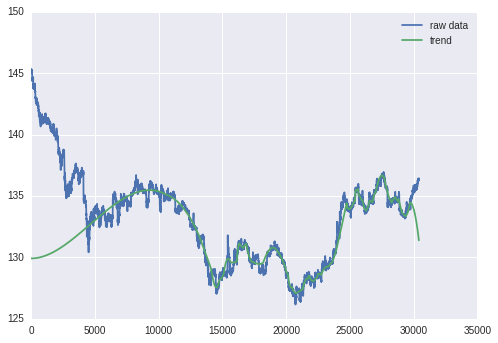

In [115]:
N = 0
M = -1
data_mini = high_data[N:M]
decomposed = EMD2(data_mini, n_step=10)
trend = decomposed[-1]
plt.plot(data_mini, label="raw data")
plt.plot(trend, label="trend")
plt.legend()

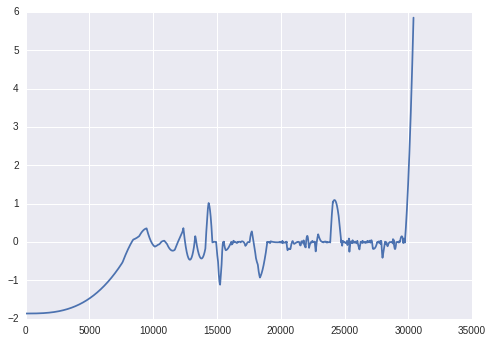

In [116]:
plt.plot(decomposed[-2], label="trend")

Noise is too small. It's bette to make the scale of noise bigger.

One of the possible reasons causing this is that envelops fits data too much.

In [117]:
def compute_envelop2(data, degree=3, is_max=True):
    """Return envelop data with local maximal(minimum)"""
    if is_max is False:
        data = -data
    
    n_data = len(data)
    index_data = np.arange(n_data)
    
    # select points for drawing line
    max_idx = get_locmax(data)
    locmax_data = data[max_idx]
    
    # reshape for regression
    X_pred = np.atleast_2d(index_data).T
    X = X_pred[max_idx]
    Y =  np.atleast_2d(locmax_data).T
    
    # interpolation
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    n_max_idx = len(max_idx)
    # if there is not so many local maimum, we don't have to smooth data
    if n_max_idx < degree:
        if is_max is False:
            data = -data
        return data
        
    model.fit(X, Y)
    envelop = model.predict(X_pred)[:, 0]
    
    envelop = np.array(envelop)
    if is_max is False:
        envelop = -envelop
    
    return envelop

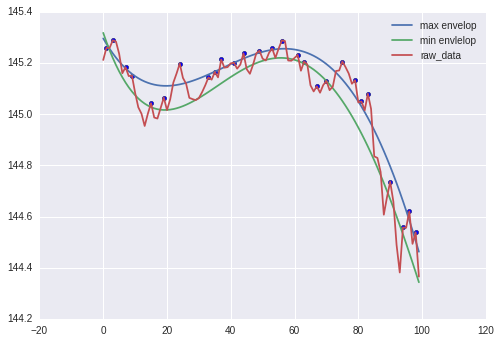

In [122]:
open_data_mini = open_data[:100]

max_envelop = compute_envelop2(open_data_mini, degree=4, is_max=True)
min_envelop = compute_envelop2(open_data_mini, degree=4, is_max=False)
x = get_locmax(open_data_mini)
y = open_data_mini[x]
plt.scatter(x, y)
plt.plot(max_envelop, label="max envelop")
plt.plot(min_envelop, label="min envlelop")
plt.plot(open_data_mini, label="raw_data")
plt.legend()

In [137]:
def EMD4(data, n_step=10, eps=1e-2):
    """Return list of decomposition"""
    decomposed_data = []
    for i in xrange(n_step):
        max_env = compute_envelop2(data, degree=4, is_max=True)
        min_env = compute_envelop2(data, degree=4, is_max=False)
        mean =  0.5 * (max_env + min_env)
        d = data - mean
        if np.max(np.abs(d)) < eps:
            break
        decomposed_data.append(d)
    
        data  = mean
        
    decomposed_data.append(mean)
    return decomposed_data

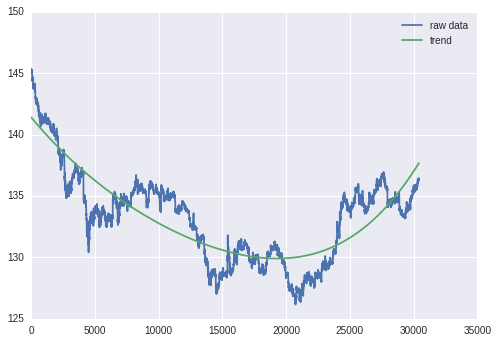

In [128]:
N = 0
M = -1
data_mini = high_data[N:M]
decomposed = EMD4(data_mini, n_step=10)
trend = decomposed[-1]
plt.plot(data_mini, label="raw data")
plt.plot(trend, label="trend")
plt.legend()

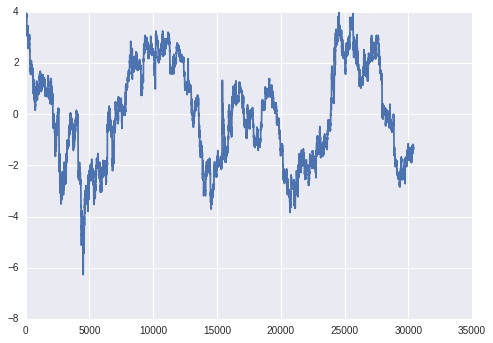

In [129]:
plt.plot(decomposed[-2], label="trend")

In [130]:
plt.plot(decomposed[-3], label="trend")

IndexError: list index out of range

# Detrend Twice

In [159]:
def EMD5(data, n_step=10, eps=1e-2):
    """Return list of decomposition"""
    # get rid of large scale trend
    trend = EMD4(data, n_step=n_step, eps=eps)[-1]
    data = data - trend
    
    decomposed_data = EMD3(data, n_step=n_step, eps=eps)
    decomposed_data.append(trend)
    return decomposed_data

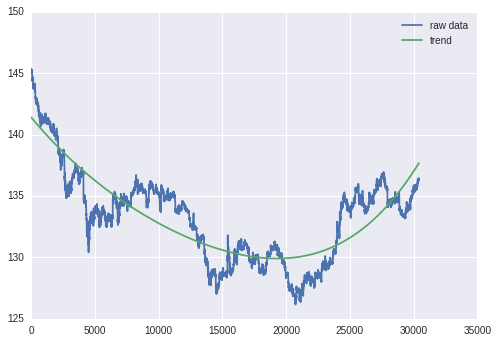

In [163]:
N = 0
M = -1
data_mini = high_data[N:M]
decomposed = EMD5(data_mini, n_step=10)
trend = decomposed[-1]
plt.plot(data_mini, label="raw data")
plt.plot(trend, label="trend")
plt.legend()

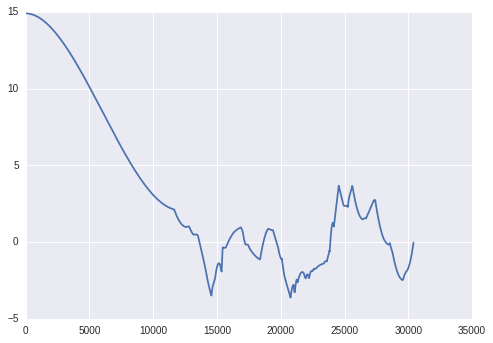

In [164]:
plt.plot(decomposed[-2])

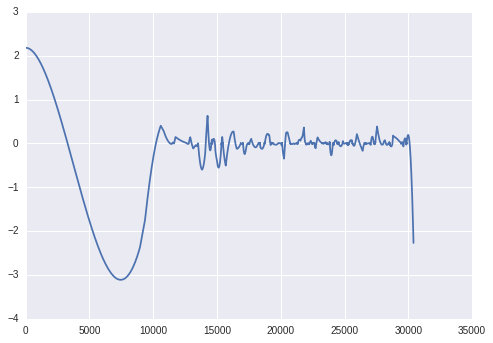

In [165]:
plt.plot(decomposed[-3])

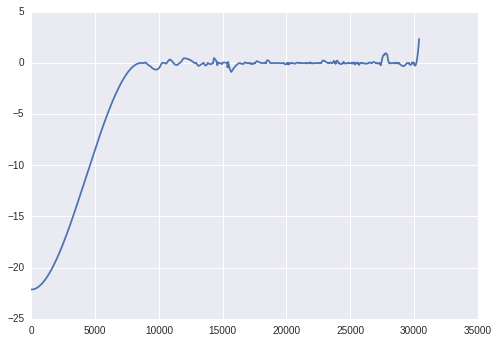

In [166]:
plt.plot(decomposed[-4])